In [1]:
import pyrootutils
import os
# combines find_root() and set_root() into one method
root = pyrootutils.setup_root(
    search_from=os.getcwd(),
    indicator=".gitignore",  # search for this file to find the root
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True,
)

In [2]:
from pathlib import Path
import argparse

import numpy as np

import datasets
datasets.disable_caching()
import torch

from attack_utils.sig import SigTriggerAttack
from model_zoo import get_model
from utils.data import DataModule, build_transform
from utils.train import get_optimizer, SecondSplitTrainer
from utils import set_seed, add_comm_arguments
from utils.ssft import get_first_epoch_where_we_learn_forever, get_first_epoch_where_we_forget_forever

import matplotlib.pyplot as plt

In [3]:
def create_parser():
    parser = argparse.ArgumentParser(description="Argument parser for the script")
    add_comm_arguments(parser)
    # Poisoning paramerters
    parser.add_argument('--trigger_delta', type=float, default=20, help='Size of the trigger')
    parser.add_argument('--trigger_f', type=float, default=6, help='Size of the trigger')

    return parser

args = create_parser().parse_args("--trainset_portion 0.2 --epochs 50 --poisoning_rate 0.005 --model_name resnet18 --lr 0.1 --optimizer_name sgd --seed 42 --ood_dataset nnheui/cifar10_2 --ood_percent 1.0 --device cuda:4".split())

In [4]:
set_seed(args.seed)

In [5]:
dm = DataModule(args)
triggle_handler = SigTriggerAttack(
    args.trigger_label,
    dm.hparams.image_shape, 
    args.trigger_delta, 
    args.trigger_f)
dm.subsample_trainset()
dm.setup_poisoned_sets(triggle_handler)
dm.setup_ood(args.ood_dataset, shuffle_seed=args.shuffle_seed, kept_percent=args.ood_percent)
# dm.setup_ood(args.dataset, shuffle_seed=args.shuffle_seed)
# kept_size = int(dm.hparams.trainset_orig_size * dm.hparams.trainset_portion)
# dm.ood_ds['train'] = dm.ood_ds['train'].select(range(kept_size, kept_size*2))

args.data_hparams = vars(dm.hparams)

# dm.apply_transform()

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Trainset size: 10000
[('airplane', 1024), ('automobile', 1019), ('bird', 990), ('cat', 1010), ('deer', 1021), ('dog', 1020), ('frog', 974), ('horse', 937), ('ship', 1000), ('truck', 1005)]
Poison_size 250


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Poisoned Trainset
[('airplane', 1257), ('automobile', 994), ('bird', 970), ('cat', 977), ('deer', 991), ('dog', 998), ('frog', 943), ('horse', 918), ('ship', 973), ('truck', 979)]


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

OOD set size: 10000


In [6]:
apply_train_transform, apply_transform, detransform = build_transform("CIFAR10", has_augmentation=True)
train_poisoned_ds = dm.base_ds['train_poisoned']
val_poisoned_ds = dm.base_ds['test_poisoned']
val_clean_ds = dm.base_ds['test']
ft_ds = dm.ood_ds['train']

def reid(e, i):
    e['reid'] = i
    return e

train_poisoned_ds = train_poisoned_ds.map(reid, with_indices=True)
val_poisoned_ds = val_poisoned_ds.map(reid, with_indices=True)
val_clean_ds = val_clean_ds.map(reid, with_indices=True)
ft_ds = ft_ds.map(reid, with_indices=True)

train_poisoned_ds.set_transform(apply_train_transform)
ft_ds.set_transform(apply_train_transform)
val_poisoned_ds.set_transform(apply_transform)
val_clean_ds.set_transform(apply_transform)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
args.batch_size = 256
def collate_fn(examples):
    inputs = torch.stack([example["inputs"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    ids = torch.tensor([example["reid"] for example in examples])
    return {
        "inputs": inputs,
        "labels": labels,
        "ids": ids
    }

train_poisoned_dl = torch.utils.data.DataLoader(
    train_poisoned_ds, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=4,
    collate_fn=collate_fn
)

val_poisoned_dl = torch.utils.data.DataLoader(
    val_poisoned_ds, 
    batch_size=args.batch_size, 
    shuffle=False, 
    num_workers=4,
    collate_fn=collate_fn
)

val_clean_dl = torch.utils.data.DataLoader(
    val_clean_ds, 
    batch_size=args.batch_size, 
    shuffle=False, 
    num_workers=4,
    collate_fn=collate_fn
)

ft_dl = torch.utils.data.DataLoader(
    ft_ds, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=4,
    collate_fn=collate_fn
)


In [10]:
args.epochs = 50
model = get_model(args, num_classes=len(dm.hparams.target_names))

In [ ]:
d = torch.load("second_split_out.pt")
ret_pre = d['ret_pre']
model.load_state_dict(d['state_dict'])

In [11]:
### Create Model and Training
# optimizer = get_optimizer(args, model)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
# criterion = torch.nn.CrossEntropyLoss()

# trainer = SecondSplitTrainer()
# ret_pre = trainer.train(
#     args,
#     train_poisoned_dl, train_poisoned_dl,
#     model, criterion, optimizer, scheduler,
#     eval_every=1
# )

# torch.save({
#         "ret_pre": ret_pre,
#         "state_dict": model.state_dict()
#     },
#     "second_split_out.pt"
# )

#Stage 2 Training
optimizer = get_optimizer(args, model)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
criterion = torch.nn.CrossEntropyLoss()
ft_loader = torch.utils.data.DataLoader(dm.ood_ds['train'], batch_size=args.batch_size, shuffle=True)
trainer = SecondSplitTrainer()
ret_ft = trainer.train(
    args,
    ft_dl, train_poisoned_dl,
    model, criterion, optimizer, scheduler,
    eval_every=1
)

Start training for 50 epochs


# EPOCH 0   loss: 3.2260 Test Acc: 0.1194



# EPOCH 1   loss: 2.3626 Test Acc: 0.1891



# EPOCH 2   loss: 2.0947 Test Acc: 0.1971



# EPOCH 3   loss: 2.0924 Test Acc: 0.2142



# EPOCH 4   loss: 1.9669 Test Acc: 0.2772



# EPOCH 5   loss: 1.8793 Test Acc: 0.3178



# EPOCH 6   loss: 1.8047 Test Acc: 0.3181



# EPOCH 7   loss: 1.7332 Test Acc: 0.3565



# EPOCH 8   loss: 1.6783 Test Acc: 0.3583



# EPOCH 9   loss: 1.6256 Test Acc: 0.4244



# EPOCH 10   loss: 1.5845 Test Acc: 0.4189



# EPOCH 11   loss: 1.5696 Test Acc: 0.3856



# EPOCH 12   loss: 1.6140 Test Acc: 0.4118



# EPOCH 13   loss: 1.5508 Test Acc: 0.4608



# EPOCH 14   loss: 1.4358 Test Acc: 0.4861



# EPOCH 15   loss: 1.4009 Test Acc: 0.4920



# EPOCH 16   loss: 1.3453 Test Acc: 0.4912



# EPOCH 17   loss: 1.3192 Test Acc: 0.5009



# EPOCH 18   loss: 1.2668 Test Acc: 0.5289



# EPOCH 19   loss: 1.2518 Test Acc: 0.5642



# EPOCH 20   loss: 1.2213 Test Acc: 0.5766



# EPOCH 21   loss: 1.1831 Test Acc: 0.5636



# EPOCH 22   loss: 1.1765 Test Acc: 0.5335



# EPOCH 23   loss: 1.1171 Test Acc: 0.5920



# EPOCH 24   loss: 1.0974 Test Acc: 0.5742



# EPOCH 25   loss: 1.0688 Test Acc: 0.6201



# EPOCH 26   loss: 1.0265 Test Acc: 0.6466



# EPOCH 27   loss: 1.0031 Test Acc: 0.6682



# EPOCH 28   loss: 0.9451 Test Acc: 0.6696



# EPOCH 29   loss: 0.9233 Test Acc: 0.6698



# EPOCH 30   loss: 0.8851 Test Acc: 0.6813



# EPOCH 31   loss: 0.8594 Test Acc: 0.6938



# EPOCH 32   loss: 0.8585 Test Acc: 0.7114



# EPOCH 33   loss: 0.8029 Test Acc: 0.7174



# EPOCH 34   loss: 0.7799 Test Acc: 0.7386



# EPOCH 35   loss: 0.7542 Test Acc: 0.7562



# EPOCH 36   loss: 0.7412 Test Acc: 0.7693



# EPOCH 37   loss: 0.6994 Test Acc: 0.7562



# EPOCH 38   loss: 0.6680 Test Acc: 0.7796



# EPOCH 39   loss: 0.6245 Test Acc: 0.7888



# EPOCH 40   loss: 0.6088 Test Acc: 0.7904



# EPOCH 41   loss: 0.5773 Test Acc: 0.8053



# EPOCH 42   loss: 0.5851 Test Acc: 0.8111



# EPOCH 43   loss: 0.5535 Test Acc: 0.8144



# EPOCH 44   loss: 0.5282 Test Acc: 0.8146



# EPOCH 45   loss: 0.5212 Test Acc: 0.8269



# EPOCH 46   loss: 0.5116 Test Acc: 0.8303



# EPOCH 47   loss: 0.5006 Test Acc: 0.8295



# EPOCH 48   loss: 0.5014 Test Acc: 0.8293



# EPOCH 49   loss: 0.5020 Test Acc: 0.8332

Start training for 50 epochs


# EPOCH 0   loss: 0.5015 Test Acc: 0.3384



# EPOCH 1   loss: 0.4686 Test Acc: 0.3790



# EPOCH 2   loss: 0.3132 Test Acc: 0.3314



# EPOCH 3   loss: 0.2916 Test Acc: 0.2391



# EPOCH 4   loss: 0.4056 Test Acc: 0.3853



# EPOCH 5   loss: 0.2750 Test Acc: 0.3986



# EPOCH 6   loss: 0.2326 Test Acc: 0.3558



# EPOCH 7   loss: 0.2054 Test Acc: 0.3959



# EPOCH 8   loss: 0.2172 Test Acc: 0.3784



# EPOCH 9   loss: 0.1809 Test Acc: 0.3802



# EPOCH 10   loss: 0.1823 Test Acc: 0.3826



# EPOCH 11   loss: 0.1950 Test Acc: 0.3813



# EPOCH 12   loss: 0.1421 Test Acc: 0.3737



# EPOCH 13   loss: 0.1293 Test Acc: 0.3970



# EPOCH 14   loss: 0.1803 Test Acc: 0.3812



# EPOCH 15   loss: 0.1470 Test Acc: 0.3699



# EPOCH 16   loss: 0.1587 Test Acc: 0.3906



# EPOCH 17   loss: 0.1333 Test Acc: 0.3601



# EPOCH 18   loss: 0.1517 Test Acc: 0.3636



# EPOCH 19   loss: 0.1504 Test Acc: 0.4162



# EPOCH 20   loss: 0.1541 Test Acc: 0.4100



# EPOCH 21   loss: 0.1029 Test Acc: 0.3957



# EPOCH 22   loss: 0.1123 Test Acc: 0.3601



# EPOCH 23   loss: 0.1398 Test Acc: 0.3930



# EPOCH 24   loss: 0.1015 Test Acc: 0.3860



# EPOCH 25   loss: 0.0839 Test Acc: 0.3978



# EPOCH 26   loss: 0.1016 Test Acc: 0.4087



# EPOCH 27   loss: 0.1023 Test Acc: 0.3917



# EPOCH 28   loss: 0.0978 Test Acc: 0.3969



# EPOCH 29   loss: 0.0655 Test Acc: 0.4119



# EPOCH 30   loss: 0.0838 Test Acc: 0.3910



# EPOCH 31   loss: 0.0839 Test Acc: 0.3800



# EPOCH 32   loss: 0.0680 Test Acc: 0.3984



# EPOCH 33   loss: 0.0650 Test Acc: 0.4111



# EPOCH 34   loss: 0.0527 Test Acc: 0.4008



# EPOCH 35   loss: 0.0602 Test Acc: 0.4011



# EPOCH 36   loss: 0.0488 Test Acc: 0.4035



# EPOCH 37   loss: 0.0565 Test Acc: 0.4041



# EPOCH 38   loss: 0.0547 Test Acc: 0.3946



# EPOCH 39   loss: 0.0531 Test Acc: 0.3991



# EPOCH 40   loss: 0.0438 Test Acc: 0.4057



# EPOCH 41   loss: 0.0456 Test Acc: 0.4179



# EPOCH 42   loss: 0.0427 Test Acc: 0.4057



# EPOCH 43   loss: 0.0304 Test Acc: 0.4058



# EPOCH 44   loss: 0.0313 Test Acc: 0.4030



# EPOCH 45   loss: 0.0381 Test Acc: 0.3975



# EPOCH 46   loss: 0.0319 Test Acc: 0.4081



# EPOCH 47   loss: 0.0309 Test Acc: 0.4034



# EPOCH 48   loss: 0.0290 Test Acc: 0.4043



# EPOCH 49   loss: 0.0373 Test Acc: 0.4021



In [12]:
is_poisoned = [train_poisoned_ds[i]['is_poison'] for i in range(len(train_poisoned_ds))]

In [13]:
sum(is_poisoned)

250

In [14]:
poisoned_size=sum(is_poisoned)

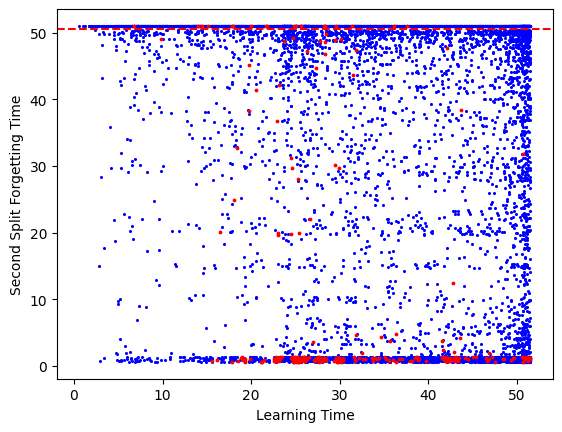

In [15]:
masks_pre = ret_pre["mask_list_tr"]
masks_ft = ret_ft["mask_list_tr"]
# noise_mask = pre_dict["noise_mask"]

learn_epochs = get_first_epoch_where_we_learn_forever(masks_pre)
forget_epochs = get_first_epoch_where_we_forget_forever(masks_ft)
learn = learn_epochs + np.random.uniform(-0.5, 0.5, size = learn_epochs.shape)
forget = forget_epochs 
fg = forget_epochs.max()
forget[forget_epochs!=fg] = forget[forget_epochs!=fg] + np.random.uniform(-0.4, 0.4, size = forget_epochs[forget_epochs!=fg].shape)
plt.xlabel("Learning Time")
plt.ylabel("Second Split Forgetting Time")

plt.axhline(y=fg-0.5, color='r', linestyle='--')


plt.scatter(learn[poisoned_size:], forget[poisoned_size:], s= 1.5, c = "b")
plt.scatter(learn[:poisoned_size], forget[:poisoned_size], s= 3, c = "r")

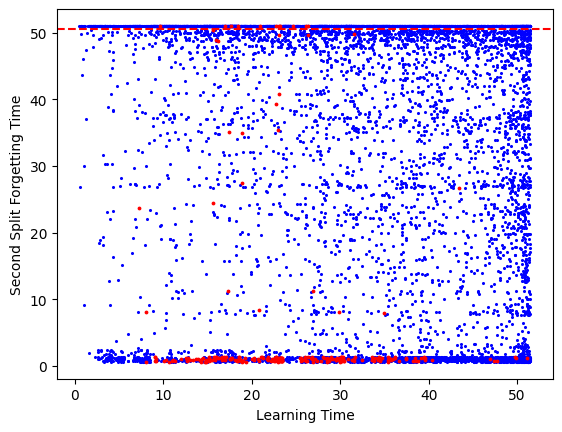

In [29]:
masks_pre = ret_pre["mask_list_tr"]
masks_ft = ret_ft["mask_list_tr"]
# noise_mask = pre_dict["noise_mask"]

learn_epochs = get_first_epoch_where_we_learn_forever(masks_pre)
forget_epochs = get_first_epoch_where_we_forget_forever(masks_ft)
learn = learn_epochs + np.random.uniform(-0.5, 0.5, size = learn_epochs.shape)
forget = forget_epochs 
fg = forget_epochs.max()
forget[forget_epochs!=fg] = forget[forget_epochs!=fg] + np.random.uniform(-0.4, 0.4, size = forget_epochs[forget_epochs!=fg].shape)
plt.xlabel("Learning Time")
plt.ylabel("Second Split Forgetting Time")

plt.axhline(y=fg-0.5, color='r', linestyle='--')


plt.scatter(learn[poisoned_size:], forget[poisoned_size:], s= 1.5, c = "b")
plt.scatter(learn[:poisoned_size], forget[:poisoned_size], s= 3, c = "r")

In [16]:
import matplotlib
import numpy as np
import matplotlib.gridspec as gridspec

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.use('svg')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"

In [17]:

# x, y  = learn[:250], forget[:250]
x, y  = learn[poisoned_size:], forget[poisoned_size:]
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:, :4])
ax_xDist = plt.subplot(gs[0, :4])#,sharex=ax_main)
ax_yDist = plt.subplot(gs[1:, 4])#,sharey=ax_main)

ax_main.scatter(x,y,marker='.',c='tab:blue',s=50)
ax_main.set(xlabel="Learning Time", ylabel="Second Split Forgetting Time")
ax_main.axhline(y=fg-0.5, color='tab:red', linestyle='--', c = 'tab:red')
ax_xDist.hist(x,bins=61,color='tab:red',align='mid')
ax_xDist.set(ylabel='#Examples')

ax_yDist.hist(y,bins=61,color='tab:red', orientation='horizontal',align='mid')
ax_yDist.set(xlabel='#Examples')

ax_xDist.set_yscale('log')
ax_yDist.set_xscale('log')
ax_yDist.set_yticklabels([])
ax_xDist.set_xticklabels([])


# plt.savefig("plots/mnist_vis.svg")
# plt.show()
# fig

[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, '')]

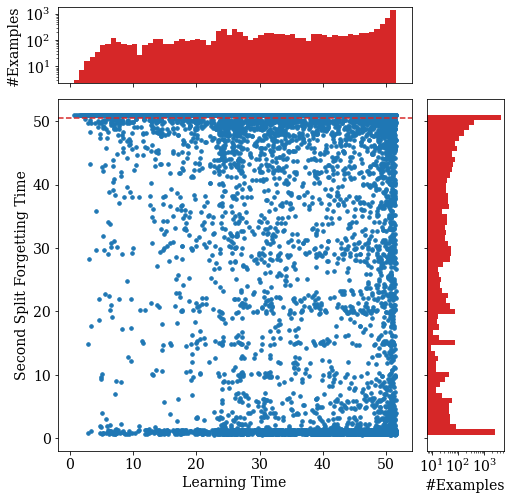

In [18]:
fig

In [38]:

# x, y  = learn[:250], forget[:250]
x, y  = learn[poisoned_size:], forget[poisoned_size:]
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:, :4])
ax_xDist = plt.subplot(gs[0, :4])#,sharex=ax_main)
ax_yDist = plt.subplot(gs[1:, 4])#,sharey=ax_main)

ax_main.scatter(x,y,marker='.',c='tab:blue',s=50)
ax_main.set(xlabel="Learning Time", ylabel="Second Split Forgetting Time")
ax_main.axhline(y=fg-0.5, color='tab:red', linestyle='--', c = 'tab:red')
ax_xDist.hist(x,bins=61,color='tab:red',align='mid')
ax_xDist.set(ylabel='#Examples')

ax_yDist.hist(y,bins=61,color='tab:red', orientation='horizontal',align='mid')
ax_yDist.set(xlabel='#Examples')

ax_xDist.set_yscale('log')
ax_yDist.set_xscale('log')
ax_yDist.set_yticklabels([])
ax_xDist.set_xticklabels([])


# plt.savefig("plots/mnist_vis.svg")
# plt.show()
# fig

[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, '')]

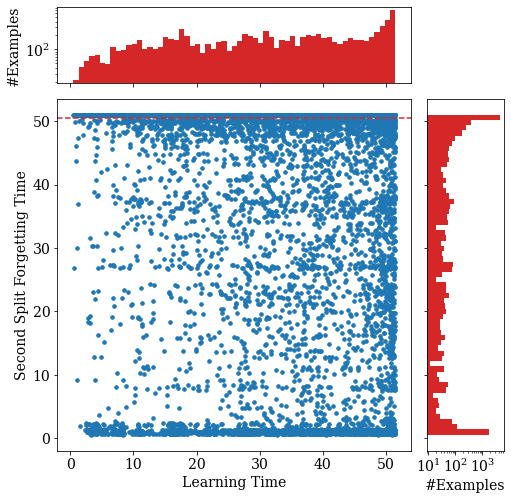

In [39]:
fig